# **1. Importing Required Libraries**

In [ ]:
# Importing
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

# **2. Function Definitions**

## **2.1 Mesh Generation**

In [ ]:
def mesh(Nx, Ny):
    dx, dy = 1 / Nx, 1 / Ny
    x_line = np.linspace(0 - dx / 2, 1 + dx / 2, Nx + 2)
    y_line = np.linspace(1 + dy / 2, 0 - dy / 2, Ny + 2)
    m, n = np.meshgrid(x_line, y_line, indexing='xy')
    return m, n

## **2.2 Boundary Condition Implementation**

In [ ]:
def boundary_condition(T, Nx, Ny):
    [m, n] = mesh(Nx, Ny)

    T[0, :] = 2*np.sin(np.pi * m[0, :])-T[1,:]
    T[Nx + 1, :] = -T[Nx,:]
    T[:, Ny + 1] = -T[:,Ny]
    T[:, 0] = -T[:,1]

    return

## **2.3 Exact Solution Computation**

In [ ]:
def T_exact(Nx, Ny):
    m, n = mesh(Nx, Ny)
    x, y = m[1:-1, 1:-1], n[1:-1, 1:-1]
    T_ext = np.sin(np.pi * x) * np.sinh(np.pi * y) / np.sinh(np.pi)
    return T_ext


## **2.4 Error Norm Calculation**

In [ ]:
def norm(T, Nx, Ny):
    T_ext = T_exact(Nx, Ny)
    Error = np.abs(T_ext - T)
    L_1 = np.mean(Error)
    L_2 = np.sqrt(np.mean(Error ** 2))
    L_inf = np.max(Error)
    return L_1,L_2,L_inf

## **2.5 Numerical Methods Implementation**

### **2.5.1 Gauss-Seidel Method**

In [ ]:
def Gauss_Seidel(Nx, Ny, l_2):
    T = np.zeros([Nx + 2, Ny + 2])
    dx, dy = 1 / Nx, 1 / Ny
    L = []
    iteration = []

    L2 = 1
    counter = 0
    while L2 > l_2:

        boundary_condition(T, Nx, Ny)
        T_0 = T.copy()

        for m in range(1,Nx+1):
            for n in range(1, Ny+1):
                T[m,n] = 0.5*(dy**2/((dy**2+dx**2))*(T_0[m,n+1]+T[m,n-1])+dx**2/((dy**2+dx**2))*(T[m-1,n]+T_0[m+1,n]))

        Error = np.abs(T_0[1:Nx+1, 1:Ny+1] - T[1:Nx+1, 1:Ny+1])
        L2 = np.sqrt(np.mean(Error**2))
        L.append(L2)
        counter += 1
        iteration.append(counter)
    L = np.array(L)
    iteration = np.array(iteration)
    return T[1:Nx+1, 1:Ny+1], iteration, L


### **2.5.2 Successive Over-Relaxation (SOR) Method**

In [ ]:
def SOR(Nx, Ny, omega):
    T = np.zeros([Nx + 2, Ny + 2])
    deltaT=np.zeros([Nx+2,Ny+2])
    L = []
    iteration = []
    dx = 1 / Nx
    dy = 1 / Ny
    L2 = 1
    counter = 0

    while L2 > 1e-12:
        boundary_condition(T, Nx, Ny)
        T_0 = T.copy()
        for m in range(1,Nx+1):
            for n in range(1,Ny+1):
                deltaT[m,n]=dy**2/(2*(dx**2+dy**2))*(T_0[m,n+1]+T[m,n-1])+dx**2/(2*(dx**2+dy**2))*(T_0[m+1,n]+T[m-1,n])-T_0[m,n]
                T[m,n]=T_0[m,n]+omega*deltaT[m,n]

        Error = np.abs(T_0[1:Nx + 1, 1:Ny + 1] - T[1:Nx + 1, 1:Ny + 1])
        L2 = np.sqrt(np.sum(Error ** 2) / (Nx * Ny))
        L.append(L2)
        counter += 1
        iteration.append(counter)
    L = np.array(L)
    iteration = np.array(iteration)
    return T[1:Nx + 1, 1:Ny + 1], iteration, L



### **2.5.3 Line Successive Over-Relaxation (LSOR) Method**

In [ ]:
def LSOR(Nx, Ny, omega):
    L = []
    iteration = []
    dx, dy = 1 / Nx, 1 / Ny
    C= dx**2/(2*(dx**2+dy**2))
    T = np.zeros([Nx + 2, Ny + 2])
    A= np.zeros([Nx+2,Ny+2])


    #Coefficient matrix
    for i in range(1,Nx+1):
        for j in range(1, Ny + 1):
            if i == j and i != 1 and i != Nx:
                A[i, j] = 1
            if i == j and (i == 1 or i == Nx):
                A[i, j] = 1 + C
            if j == i + 1 or j == i - 1:
                A[i, j] = -C


    deltaT = np.zeros([Nx+2,Ny+2])
    L2 = 1
    counter = 0

    while L2 > 1e-12:

        boundary_condition(T, Nx, Ny)
        T_0 = T.copy()

        for j in range(1,Ny+1):
            B = np.zeros([Nx + 2, 1])
            for i in range(1,Nx+1):
                    B[i,0] = dx ** 2 / (2 * (dx ** 2 + dy ** 2)) * (T_0[i-1,j]+T_0[i+1,j])+dy**2/(2*(dx**2+dy**2))*(T_0[i,j+1]+T[i,j-1])-T_0[i,j]
            deltaT[1:Ny+1,j] = spsolve(A[1:Nx + 1, 1:Ny + 1],B[1:Nx + 1, 0])
            T[1:Ny + 1, j] = T_0[1:Ny + 1, j] + omega * deltaT[1:Ny + 1, j]
        Error = np.abs(T_0[1:Nx + 1, 1:Ny + 1] - T[1:Nx + 1, 1:Ny + 1])

        L2 = np.sqrt(np.mean(Error ** 2))
        L.append(L2)
        counter += 1
        iteration.append(counter)
    L = np.array(L)
    iteration = np.array(iteration)
    return T[1:Nx+1, 1:Ny+1], iteration, L



<ipython-input-8-701f4e7212ea>:34: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT[1:Ny+1,j] = spsolve(A[1:Nx + 1, 1:Ny + 1],B[1:Nx + 1, 0])


[[0.1322 0.3835 0.5974 0.7528 0.8344 0.8344 0.7528 0.5974 0.3835 0.1322]
 [0.0966 0.2802 0.4364 0.5499 0.6096 0.6096 0.5499 0.4364 0.2802 0.0966]
 [0.0704 0.2043 0.3182 0.4009 0.4445 0.4445 0.4009 0.3182 0.2043 0.0704]
 [0.0511 0.1484 0.2311 0.2912 0.3228 0.3228 0.2912 0.2311 0.1484 0.0511]
 [0.0369 0.107  0.1666 0.21   0.2328 0.2328 0.21   0.1666 0.107  0.0369]
 [0.0262 0.0761 0.1185 0.1493 0.1655 0.1655 0.1493 0.1185 0.0761 0.0262]
 [0.0181 0.0526 0.0819 0.1032 0.1144 0.1144 0.1032 0.0819 0.0526 0.0181]
 [0.0118 0.0343 0.0534 0.0673 0.0746 0.0746 0.0673 0.0534 0.0343 0.0118]
 [0.0067 0.0193 0.0301 0.0379 0.042  0.042  0.0379 0.0301 0.0193 0.0067]
 [0.0021 0.0062 0.0097 0.0122 0.0136 0.0136 0.0122 0.0097 0.0062 0.0021]]


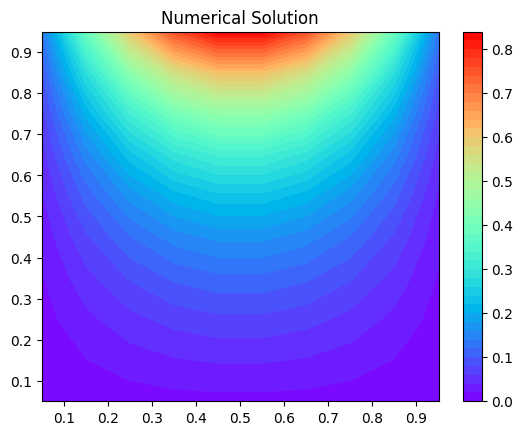

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]


In [ ]:
[T_num_line , iter_line, L2_line] = LSOR(10,10,1.3)
print(np.round(T_num_line,4))
[m,n] = mesh(10,10)
plt.contourf(m[1:11, 1:11],n[1:11, 1:11],T_num_line,50, cmap='rainbow')
plt.title('Numerical Solution')
plt.colorbar()
plt.show()
print(iter_line)

### **2.5.4 Alternating Direction Implicit (ADI) Method**

In [ ]:
def ADI(Nx, Ny, omega):
    L = []
    iteration = []
    T = np.zeros([Nx + 2, Ny + 2])
    T_half=np.zeros([Nx + 2, Ny + 2])
    dx, dy = 1 / Nx, 1 / Ny
    C1= dx**2/(2*(dx**2+dy**2))
    C2= dy**2/(2*(dx**2+dy**2))
    A1= np.zeros([Nx+2,Ny+2])
    A2= np.zeros([Nx+2,Ny+2])

    #Coefficient matrix
    for i in range(1,Nx+1):
        for j in range(1, Ny + 1):
            if i == j and i != 1 and i != Nx:
                A1[i, j] = 1
            if i == j and (i == 1 or i == Nx):
                A1[i, j] = 1 + C1
            if j == i + 1 or j == i - 1:
                A1[i, j] = -C1


    for i in range(1,Nx+1):
        for j in range(1, Ny + 1):
            if i == j and i != 1 and i != Nx:
                A2[i, j] = 1
            if i == j and (i == 1 or i == Nx):
                A2[i, j] = 1 + C2
            if j == i + 1 or j == i - 1:
                A2[i, j] = -C2


    deltaT = np.zeros([Nx+2,Ny+2])
    deltaT_half = np.zeros([Nx+2,Ny+2])
    L2 = 1
    counter = 0

    while L2 > 1e-12:

        boundary_condition(T, Nx, Ny)
        T_0 = T.copy()

        for j in range(1,Ny+1):
            B1 = np.zeros([Nx + 2, 1])
            for i in range(1,Nx+1):
                    B1[i,0] = C1 * (T_0[i-1,j]+T_0[i+1,j])+C2*(T_0[i,j+1]+T_half[i,j-1])-T_0[i,j]
            deltaT_half[1:Ny+1,j] = spsolve(A1[1:Nx + 1, 1:Ny + 1],B1[1:Nx + 1, 0])
            T_half[1:Ny + 1, j] = T_0[1:Ny + 1, j] + omega * deltaT_half[1:Ny + 1, j]
            counter += 1
            iteration.append(counter)

        for k in range(1,Nx+1):
            B2 = np.zeros([Nx + 2, 1])
            for t in range(1,Ny+1):
                    B2[t,0]=C1*(T_half[t+1,k]+T[t-1,k])+C2*(T_half[t,k+1]+T_half[t,k-1])-T_half[t,k]
            deltaT[t,1:1+Nx] = spsolve(A2[1:Nx + 1, 1:Ny + 1],B2[1:Nx + 1, 0])
            T[k,1:1+Nx] = T_half[k, 1:1+Nx] + omega * deltaT[k, 1:1+Nx]
        Error = np.abs(T_0[1:Nx + 1, 1:Ny + 1] - T[1:Nx + 1, 1:Ny + 1])
        L2 = np.sqrt(np.mean(Error ** 2))
        L.append(L2)
        counter += 1
        iteration.append(counter)
    L = np.array(L)
    iteration = np.array(iteration)
    return T[1:Nx+1, 1:Ny+1], iteration, L


<ipython-input-10-f17a2f181e21>:47: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT_half[1:Ny+1,j] = spsolve(A1[1:Nx + 1, 1:Ny + 1],B1[1:Nx + 1, 0])
<ipython-input-10-f17a2f181e21>:56: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT[t,1:1+Nx] = spsolve(A2[1:Nx + 1, 1:Ny + 1],B2[1:Nx + 1, 0])


[[0.1725 0.3991 0.6049 0.7569 0.837  0.8361 0.7539 0.5981 0.3839 0.1323]
 [0.1507 0.3103 0.454  0.5608 0.6167 0.6143 0.553  0.4384 0.2813 0.0969]
 [0.12   0.2374 0.3401 0.4157 0.4545 0.4514 0.4056 0.3212 0.206  0.0709]
 [0.092  0.179  0.2534 0.3073 0.3343 0.331  0.2969 0.2348 0.1505 0.0518]
 [0.069  0.1333 0.1872 0.2257 0.2446 0.2414 0.2161 0.1707 0.1093 0.0376]
 [0.0509 0.0977 0.1365 0.1638 0.1768 0.174  0.1554 0.1226 0.0784 0.027 ]
 [0.0368 0.0702 0.0974 0.1162 0.1248 0.1224 0.109  0.0858 0.0548 0.0188]
 [0.0261 0.0489 0.0668 0.0787 0.0838 0.0816 0.0724 0.0568 0.0362 0.0124]
 [0.0187 0.0324 0.0421 0.0479 0.05   0.048  0.0422 0.0329 0.0208 0.007 ]
 [0.0509 0.0618 0.0559 0.0476 0.0397 0.0324 0.0253 0.0182 0.0111 0.0041]]


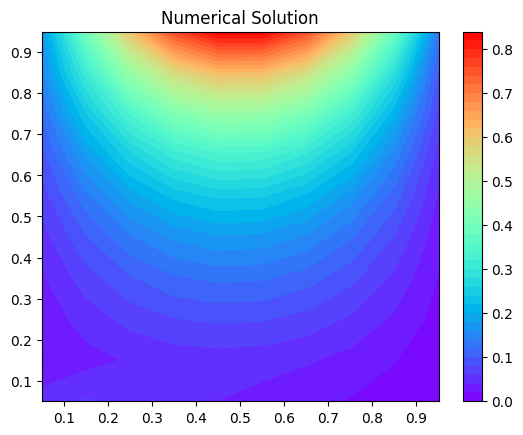

In [ ]:
# ADI Method Results for mesh 10*10
[T_num_ADI , iter_ADI, L2_ADI] = ADI(10,10,1.1)
print(np.round(T_num_ADI,4))
[m,n] = mesh(10,10)
plt.contourf(m[1:11, 1:11],n[1:11, 1:11],T_num_ADI,50, cmap='rainbow')
plt.title('Numerical Solution')
plt.colorbar()
plt.show()


### **2.5.5 Fully Implicit Method**

In [ ]:
def Fully_Implicit(Nx, Ny):
    dx,dy = 1 / Nx,1 / Ny
    [x, y] = mesh(Nx, Ny)
    X,Y = 1/dx**2, 1/dy**2
    T = np.zeros([Nx + 2, Ny + 2])
    A = np.zeros([Nx*Ny+2 , Nx*Ny+2])
    B = np.zeros([Nx * Ny + 2, 1])

    #Deining COefficient matrix

    for i in range(1,Nx*Ny+1):
        for j in range(1,Nx*Ny+1):
            if j == i:
                if i <= Nx or i > Nx*(Ny-1):
                    if i%Nx == 0 or i%Nx == 1:
                        A[i, j] = -3 * (X + Y)
                    else:
                        A[i, j] = -2*X-3*Y
                else:
                    if i%Nx == 0 or i%Nx == 1:
                        A[i, j] = -3 * X - 2 * Y
                    else:
                        A[i, j] = -2*(X+Y)
            elif j==i-1 and i%Nx != 1:
                A[i,j] = X
            elif j==i+1 and i%Nx != 0:
                A[i, j] = X
            elif j == i+Nx or i == Ny+j:
                A[i,j] = Y

    for k in range(1,Nx+1):
        B[k] = -2*Y*np.sin(np.pi*x[1,k])

    # Gaussian elimination
    for i in range(1, Nx*Ny+1):
        for j in range(i+1, Nx*Ny+1):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
            B[j] -= factor * B[i]


    sol = np.zeros_like(B)
    for i in range(Nx*Ny, 0, -1):
        summation = sum(A[i, j] * sol[j] for j in range(i+1, len(sol)))
        sol[i] = (B[i] - summation ) / A[i, i]

    #Reshaping 1D array of sol into 2D array of T
    r,s = 0,1

    for k in range(1, Nx*Ny+1):
        r += 1
        T[s,r] = sol[k]
        if (k) % Nx == 0:
            s += 1
            r = 0

    return T[1:Nx+1,1:Ny+1]


### **2.5.6 Jacobi Method**

In [ ]:
def Jacobi(Nx, Ny,l_2):
    T = np.zeros([Nx + 2, Ny + 2])
    dx,dy = 1 / Nx,1/Ny
    L2 = 1
    counter = 0

    L = []
    iteration = []

    while L2 > l_2:

        boundary_condition(T,Nx,Ny)
        T_0 = np.copy(T)
        for m in range(1, Nx+1):
            for n in range(1, Ny+1):
                T[m,n] = 0.5 * (dx**2 * (T_0[m,n+1] + T_0[m,n-1]) + dy**2 * (T_0[m-1,n] + T_0[m+1,n])) / (dx**2 + dy**2)
        Error = np.abs(T_0[1:Nx+1,1:Ny+1] - T[1:Nx+1,1:Ny+1])
        L2 = np.sqrt(np.sum(Error**2)/(Nx*Ny))
        L.append(L2)
        counter += 1
        iteration.append(counter)
    L = np.array(L)
    iteration = np.array(iteration)
    return T[1:Nx+1,1:Ny+1], iteration, L

# **3. Numerical Results and Analysis**




## **3.1 Contour Visualization of Numerical Solutions**

In this section of the project, we utilize our predefined numerical solvers to compute the temperature distribution within the domain while also analyzing their computational efficiency. We evaluate each solver's accuracy by comparing its results against the exact solution of the Laplace equation. Furthermore, we assess the impact of mesh resolution on solution accuracy by testing different grid sizes. This allows us to systematically compare the numerical error, convergence behavior, and runtime performance of each solver, providing insights into their effectiveness for solving the Laplace equation.

###**3.1.1 Gauss-Seidel Method Contour Plot**

[[0.1322 0.3835 0.5974 0.7528 0.8344 0.8344 0.7528 0.5974 0.3835 0.1322]
 [0.0966 0.2802 0.4364 0.5499 0.6096 0.6096 0.5499 0.4364 0.2802 0.0966]
 [0.0704 0.2043 0.3182 0.4009 0.4445 0.4445 0.4009 0.3182 0.2043 0.0704]
 [0.0511 0.1484 0.2311 0.2912 0.3228 0.3228 0.2912 0.2311 0.1484 0.0511]
 [0.0369 0.107  0.1666 0.21   0.2328 0.2328 0.21   0.1666 0.107  0.0369]
 [0.0262 0.0761 0.1185 0.1493 0.1655 0.1655 0.1493 0.1185 0.0761 0.0262]
 [0.0181 0.0526 0.0819 0.1032 0.1144 0.1144 0.1032 0.0819 0.0526 0.0181]
 [0.0118 0.0343 0.0534 0.0673 0.0746 0.0746 0.0673 0.0534 0.0343 0.0118]
 [0.0067 0.0193 0.0301 0.0379 0.042  0.042  0.0379 0.0301 0.0193 0.0067]
 [0.0021 0.0062 0.0097 0.0122 0.0136 0.0136 0.0122 0.0097 0.0062 0.0021]]


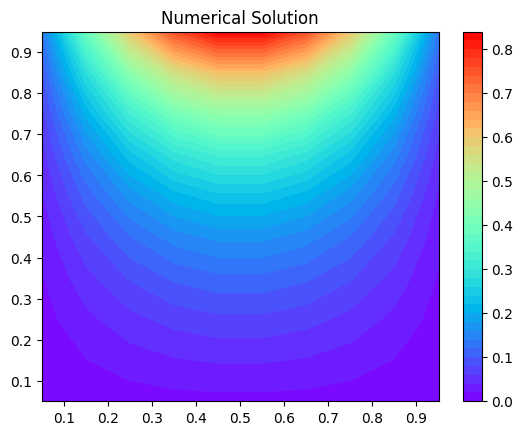

In [ ]:
#PART 1:GAUSS-SEIDEL SOLUTION
[T_num_g , iter_g, L2_g] = Gauss_Seidel(10,10,1e-10)
print(np.round(T_num_g,4))
[m,n] = mesh(10,10)
plt.contourf(m[1:11, 1:11],n[1:11, 1:11],T_num_g,50, cmap='rainbow')
plt.title('Numerical Solution')
plt.colorbar()
plt.show()

### **3.1.2 Exact Solution Contour Plot**

[[0.1336 0.3877 0.6039 0.761  0.8435 0.8435 0.761  0.6039 0.3877 0.1336]
 [0.0974 0.2826 0.4401 0.5546 0.6147 0.6147 0.5546 0.4401 0.2826 0.0974]
 [0.0708 0.2055 0.3201 0.4033 0.4471 0.4471 0.4033 0.3201 0.2055 0.0708]
 [0.0513 0.1489 0.2319 0.2923 0.324  0.324  0.2923 0.2319 0.1489 0.0513]
 [0.0369 0.1071 0.1669 0.2103 0.2331 0.2331 0.2103 0.1669 0.1071 0.0369]
 [0.0262 0.076  0.1184 0.1492 0.1654 0.1654 0.1492 0.1184 0.076  0.0262]
 [0.0181 0.0525 0.0817 0.103  0.1142 0.1142 0.103  0.0817 0.0525 0.0181]
 [0.0118 0.0341 0.0532 0.067  0.0743 0.0743 0.067  0.0532 0.0341 0.0118]
 [0.0066 0.0192 0.0299 0.0377 0.0418 0.0418 0.0377 0.0299 0.0192 0.0066]
 [0.0021 0.0062 0.0097 0.0122 0.0135 0.0135 0.0122 0.0097 0.0062 0.0021]]


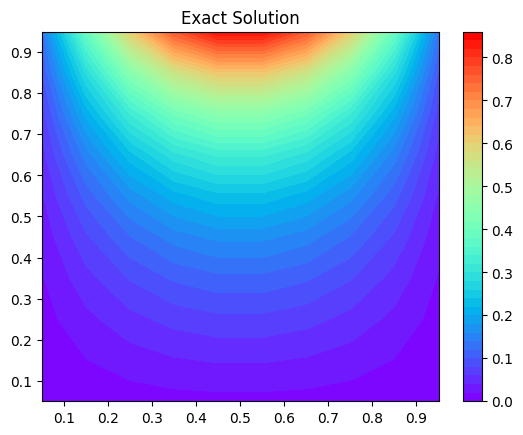

The L2 norm is: 0.002457052789547561


In [ ]:
#PART 1:EXACT SOLUTION
T_ext = T_exact(10,10)
print(np.round(T_ext,4))
[m,n] = mesh(10,10)
plt.contourf(m[1:11, 1:11],n[1:11, 1:11],T_ext,50, cmap='rainbow')
plt.title('Exact Solution')
plt.colorbar()
plt.show()
Error = np.abs(T_ext - T_num_g)
L_2_g = np.sqrt(np.mean(Error ** 2))
print("The L2 norm is:",L_2_g)

## **3.2 Runtime Evaluation and Performance Metrics**

### **3.2.1 Gauss-Seidel Method Runtime for Different Mesh Sizes**

CPU Time 10*10: 0.0679717830000186 seconds , Number of iterations: 232
CPU Time 20*20: 0.7505514009999956 seconds , Number of iterations: 888
CPU Time 30*30: 3.39428172800001 seconds , Number of iterations: 1931
CPU Time 40*40: 10.863451833999989 seconds , Number of iterations: 3345


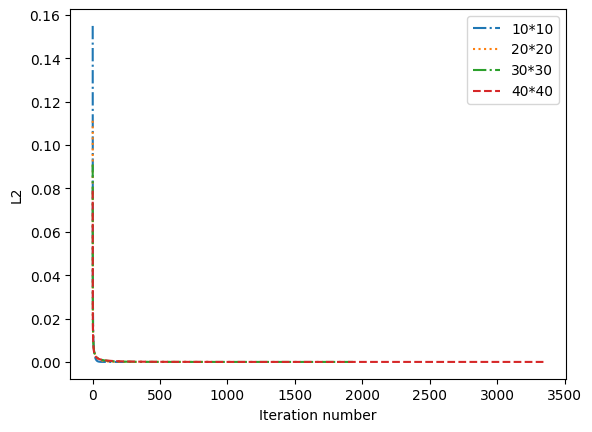

In [ ]:
#PART 2:CPU TIME CALCULATION for Gauss_Seidel Method
import timeit

start_time_g =timeit.default_timer()
[T_num_g , iter_g, L2_g] = Gauss_Seidel(10,10,1e-12)
end_time_g =timeit.default_timer()
CPU_Time_g = end_time_g - start_time_g
print(f"CPU Time 10*10: {CPU_Time_g} seconds ,","Number of iterations:",iter_g[-1])

start_time_g2 =timeit.default_timer()
[T_num_g2 , iter_g2, L2_g2] = Gauss_Seidel(20,20,1e-12)
end_time_g2 =timeit.default_timer()
CPU_Time_g2 = end_time_g2 - start_time_g2
print(f"CPU Time 20*20: {CPU_Time_g2} seconds ,","Number of iterations:",iter_g2[-1])

start_time_g3 =timeit.default_timer()
[T_num_g3 , iter_g3, L2_g3] = Gauss_Seidel(30,30,1e-12)
end_time_g3 =timeit.default_timer()
CPU_Time_g3 = end_time_g3 - start_time_g3
print(f"CPU Time 30*30: {CPU_Time_g3} seconds ,","Number of iterations:",iter_g3[-1])

start_time_g4 =timeit.default_timer()
[T_num_g4 , iter_g4, L2_g4] = Gauss_Seidel(40,40,1e-12)
end_time_g4 =timeit.default_timer()
CPU_Time_g4 = end_time_g4 - start_time_g4
print(f"CPU Time 40*40: {CPU_Time_g4} seconds ,","Number of iterations:",iter_g4[-1])


plt.plot(iter_g, L2_g, '-.', label = '10*10')
plt.plot(iter_g2, L2_g2, ':', label = '20*20')
plt.plot(iter_g3, L2_g3, '-.', label = '30*30')
plt.plot(iter_g4, L2_g4, '--', label = '40*40')
plt.xlabel('Iteration number')
plt.ylabel('L2')
plt.legend()
plt.show()

### **3.2.2 Error Norm Analysis for Gauss-Seidel Method**


In [ ]:
#PART3:NORM CALCULATION
e1=norm(T_num_g,10,10)
e2=norm(T_num_g2,20,20)
e3=norm(T_num_g3,30,30)
e4=norm(T_num_g4,40,40)

print("The norms L1, L2 and L_inf for mesh 10*10 are:",e1)
print("The norms L1, L2 and L_inf for mesh 20*20 are:",e2)
print("The norms L1, L2 and L_inf for mesh 30*30 are:",e3)
print("The norms L1, L2 and L_inf for mesh 40*40 are:",e4)

The norms L1, L2 and L_inf for mesh 10*10 are: (0.0012497324450269603, 0.0024570525085766343, 0.009095883388218873)
The norms L1, L2 and L_inf for mesh 20*20 are: (0.00032040584463506274, 0.0006386190616522282, 0.002677981567523524)
The norms L1, L2 and L_inf for mesh 30*30 are: (0.00014319807609283552, 0.0002858923572558068, 0.001250677521560939)
The norms L1, L2 and L_inf for mesh 40*40 are: (8.069871959147464e-05, 0.00016122280266302986, 0.0007204851652563571)


Order :  1.9641405067588886


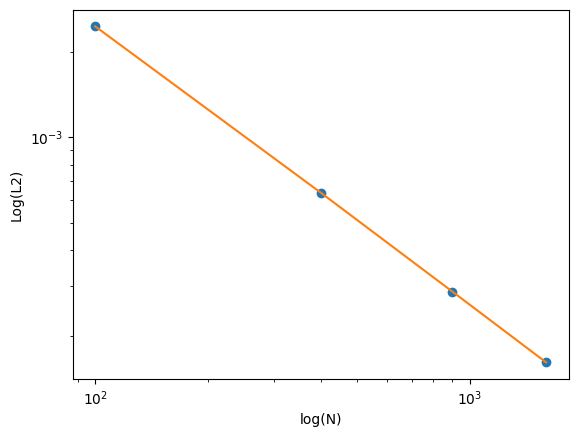

In [ ]:
#PART3: ORDER CALCULATION
Error_g = np.abs(T_exact(10,10) - T_num_g)
L_2_g = np.sqrt(np.mean(Error_g ** 2))

Error_g2 = np.abs(T_exact(20,20) - T_num_g2)
L_2_g2 = np.sqrt(np.mean(Error_g2 ** 2))

Error_g3 = np.abs(T_exact(30,30) - T_num_g3)
L_2_g3 = np.sqrt(np.mean(Error_g3 ** 2))

Error_g4 = np.abs(T_exact(40,40) - T_num_g4)
L_2_g4 = np.sqrt(np.mean(Error_g4 ** 2))

X_values,Y_values = [100,400,900,1600],[L_2_g,L_2_g2,L_2_g3,L_2_g4]
plt.xscale("log")
plt.yscale("log")
plt.plot(X_values,Y_values,'o')
plt.plot(X_values,Y_values)
plt.xlabel('log(N)')
plt.ylabel('Log(L2)')
log_X_values = np.log([100,400,900,1600])
log_Y_values= np.log([L_2_g,L_2_g2,L_2_g3,L_2_g4])
[a,b] = np.polyfit(log_X_values, log_Y_values, 1)

print('Order : ',np.abs(2*a))


### **3.2.3 Execution Time Analysis of SOR Method**

In [ ]:
#PART4: SOR TIME CALCULATION
# Omega is relaxation factor
start_time_SOR =timeit.default_timer()
[T_num_SOR , iter_SOR, L2_SOR] = SOR(40,40,1.1)
end_time_SOR =timeit.default_timer()
CPU_Time_SOR = end_time_SOR - start_time_SOR
print(f"CPU Time omega=1.1: {CPU_Time_SOR} seconds  ,", "Number of iterations: ",iter_SOR[-1])

start_time_SOR2 =timeit.default_timer()
[T_num_SOR2 , iter_SOR2, L2_SOR2] = SOR(40,40,1.3)
end_time_SOR2 =timeit.default_timer()
CPU_Time_SOR2 = end_time_SOR2 - start_time_SOR2
print(f"CPU Time omega=1.3: {CPU_Time_SOR2} seconds  ,","Number of iterations: ",iter_SOR2[-1])

start_time_SOR3 =timeit.default_timer()
[T_num_SOR3 , iter_SOR3, L2_SOR3] = SOR(40,40,1.5)
end_time_SOR3 =timeit.default_timer()
CPU_Time_SOR3 = end_time_SOR3 - start_time_SOR3
print(f"CPU Time omega=1.5: {CPU_Time_SOR3} seconds  ,","Number of iterations: ",iter_SOR3[-1])

CPU Time omega=1.1: 13.644619306000095 seconds  , Number of iterations:  2759
CPU Time omega=1.3: 8.88288469600002 seconds  , Number of iterations:  1844
CPU Time omega=1.5: 4.822694571000056 seconds  , Number of iterations:  1155


### **3.2.4 Comparative Runtime Analysis: Jacobi vs. Gauss-Seidel**

GAUSS-SEIDEL CPU Time 40*40: 11.128914834000057 seconds , Number of iterations: 3345
JACOBI CPU Time 40*40: 18.436102381999945 seconds , Number of iterations: 6483


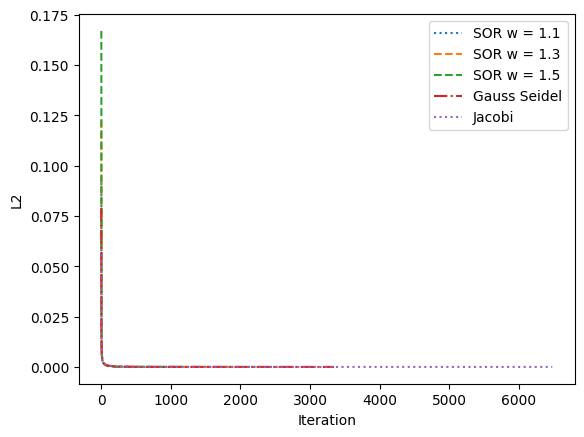

In [ ]:
#PART 4:GAUSS-SEIDEL AND JACOBI TIME CALCULATION

start_time_G4 =timeit.default_timer()
[T_num_G4 , iter_G4, L2_G4] = Gauss_Seidel(40,40,1e-12)
end_time_G4 =timeit.default_timer()
CPU_Time_G4 = end_time_G4 - start_time_G4
print(f"GAUSS-SEIDEL CPU Time 40*40: {CPU_Time_G4} seconds ,","Number of iterations:",iter_G4[-1])

start_time_J4 =timeit.default_timer()
[T_num_J4 , iter_J4, L2_J4] = Jacobi(40,40,1e-12)
end_time_J4 =timeit.default_timer()
CPU_Time_J4 = end_time_J4 - start_time_J4
print(f"JACOBI CPU Time 40*40: {CPU_Time_J4} seconds ,","Number of iterations:",iter_J4[-1])

plt.plot(iter_SOR, L2_SOR, ':', label = 'SOR w = 1.1')
plt.plot(iter_SOR2, L2_SOR2, '--', label = 'SOR w = 1.3')
plt.plot(iter_SOR3, L2_SOR3, '--', label = 'SOR w = 1.5')
plt.plot(iter_G4, L2_G4, '-.', label = 'Gauss Seidel')
plt.plot(iter_J4, L2_J4, ':', label = 'Jacobi')
plt.xlabel('Iteration')
plt.ylabel('L2')
plt.legend()

plt.show()

### **3.2.5 Comparative Runtime Analysis: LSOR vs. SOR**

<ipython-input-8-701f4e7212ea>:34: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT[1:Ny+1,j] = spsolve(A[1:Nx + 1, 1:Ny + 1],B[1:Nx + 1, 0])


CPU Time omega=1.1 for mesh 10*10: 0.24662906799994744 seconds  , Number of iterations:  100
CPU Time omega=1.1 for mesh 20*20: 2.0348044049999316 seconds  , Number of iterations:  381
CPU Time omega=1.1 for mesh 40*40: 19.991372917000035 seconds  , Number of iterations:  1433
CPU Time omega=1.1 for mesh 10*10: 0.1303329269999267 seconds  , Number of iterations:  189
CPU Time omega=1.1 for mesh 20*20: 0.9935800619998645 seconds  , Number of iterations:  730
CPU Time omega=1.1 for mesh 40*40: 12.67221573300003 seconds  , Number of iterations:  2759


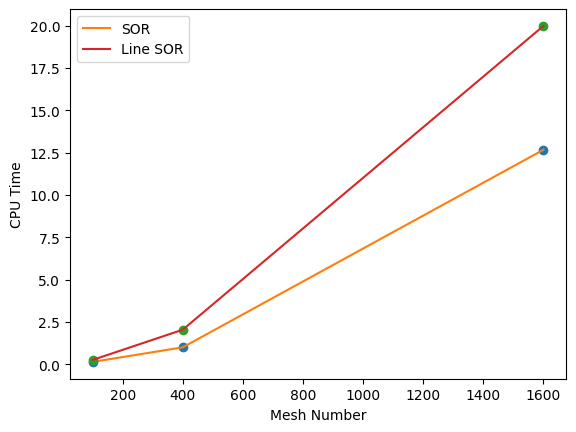

In [ ]:
start_time_lsor =timeit.default_timer()
[T_num_lsor , iter_lsor, L2_lsor] = LSOR(10,10,1.1)
end_time_lsor =timeit.default_timer()
CPU_Time_lsor = end_time_lsor - start_time_lsor
print(f"CPU Time omega=1.1 for mesh 10*10: {CPU_Time_lsor} seconds  ,", "Number of iterations: ",iter_lsor[-1])

start_time_lsor2 =timeit.default_timer()
[T_num_lsor2 , iter_lsor2, L2_lsor2] = LSOR(20,20,1.1)
end_time_lsor2 =timeit.default_timer()
CPU_Time_lsor2 = end_time_lsor2 - start_time_lsor2
print(f"CPU Time omega=1.1 for mesh 20*20: {CPU_Time_lsor2} seconds  ,", "Number of iterations: ",iter_lsor2[-1])

start_time_lsor3 =timeit.default_timer()
[T_num_lsor3 , iter_lsor3, L2_lsor3] = LSOR(40,40,1.1)
end_time_lsor3 =timeit.default_timer()
CPU_Time_lsor3 = end_time_lsor3 - start_time_lsor3
print(f"CPU Time omega=1.1 for mesh 40*40: {CPU_Time_lsor3} seconds  ,", "Number of iterations: ",iter_lsor3[-1])

start_time_SORR =timeit.default_timer()
[T_num_SORR , iter_SORR, L2_SORR] = SOR(10,10,1.1)
end_time_SORR =timeit.default_timer()
CPU_Time_SORR = end_time_SORR - start_time_SORR
print(f"CPU Time omega=1.1 for mesh 10*10: {CPU_Time_SORR} seconds  ,", "Number of iterations: ",iter_SORR[-1])

start_time_SORR2 =timeit.default_timer()
[T_num_SORR2 , iter_SORR2, L2_SORR2] = SOR(20,20,1.1)
end_time_SORR2 =timeit.default_timer()
CPU_Time_SORR2 = end_time_SORR2 - start_time_SORR2
print(f"CPU Time omega=1.1 for mesh 20*20: {CPU_Time_SORR2} seconds  ,","Number of iterations: ",iter_SORR2[-1])

start_time_SORR3 =timeit.default_timer()
[T_num_SORR3 , iter_SORR3, L2_SORR3] = SOR(40,40,1.1)
end_time_SORR3 =timeit.default_timer()
CPU_Time_SORR3 = end_time_SORR3 - start_time_SORR3
print(f"CPU Time omega=1.1 for mesh 40*40: {CPU_Time_SORR3} seconds  ,","Number of iterations: ",iter_SORR3[-1])

x_value = [100,400,1600]
y_value_sor = [CPU_Time_SORR, CPU_Time_SORR2, CPU_Time_SORR3]
y_value_lsor = [CPU_Time_lsor, CPU_Time_lsor2, CPU_Time_lsor3]
plt.plot(x_value, y_value_sor,'o')
plt.plot(x_value, y_value_sor, label = 'SOR')
plt.plot(x_value, y_value_lsor,'o')
plt.plot(x_value, y_value_lsor, label = 'Line SOR')
plt.xlabel('Mesh Number')
plt.ylabel('CPU Time')
plt.legend()
plt.show()



In [ ]:
start_time_ADI =timeit.default_timer()
[T_num_ADI , iter_ADI, L2_ADI] = ADI(10,10,1.1)
end_time_ADI =timeit.default_timer()
CPU_Time_ADI = end_time_ADI - start_time_ADI
print(f"CPU Time omega=1.1 for mesh 10*10: {CPU_Time_ADI} seconds  ,", "Number of iterations: ",iter_ADI[-1])

<ipython-input-10-f17a2f181e21>:47: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT_half[1:Ny+1,j] = spsolve(A1[1:Nx + 1, 1:Ny + 1],B1[1:Nx + 1, 0])
<ipython-input-10-f17a2f181e21>:56: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT[t,1:1+Nx] = spsolve(A2[1:Nx + 1, 1:Ny + 1],B2[1:Nx + 1, 0])


CPU Time omega=1.1 for mesh 10*10: 0.4820651810000527 seconds  , Number of iterations:  1177


### **3.2.6 Fully Implicit Method Contour Plot**

<ipython-input-26-c83bb3da1e8c>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T[s,r] = sol[k]


[[0.1322 0.3835 0.5974 0.7528 0.8344 0.8344 0.7528 0.5974 0.3835 0.1322]
 [0.0966 0.2802 0.4364 0.5499 0.6096 0.6096 0.5499 0.4364 0.2802 0.0966]
 [0.0704 0.2043 0.3182 0.4009 0.4445 0.4445 0.4009 0.3182 0.2043 0.0704]
 [0.0511 0.1484 0.2311 0.2912 0.3228 0.3228 0.2912 0.2311 0.1484 0.0511]
 [0.0369 0.107  0.1666 0.21   0.2328 0.2328 0.21   0.1666 0.107  0.0369]
 [0.0262 0.0761 0.1185 0.1493 0.1655 0.1655 0.1493 0.1185 0.0761 0.0262]
 [0.0181 0.0526 0.0819 0.1032 0.1144 0.1144 0.1032 0.0819 0.0526 0.0181]
 [0.0118 0.0343 0.0534 0.0673 0.0746 0.0746 0.0673 0.0534 0.0343 0.0118]
 [0.0067 0.0193 0.0301 0.0379 0.042  0.042  0.0379 0.0301 0.0193 0.0067]
 [0.0021 0.0062 0.0097 0.0122 0.0136 0.0136 0.0122 0.0097 0.0062 0.0021]]


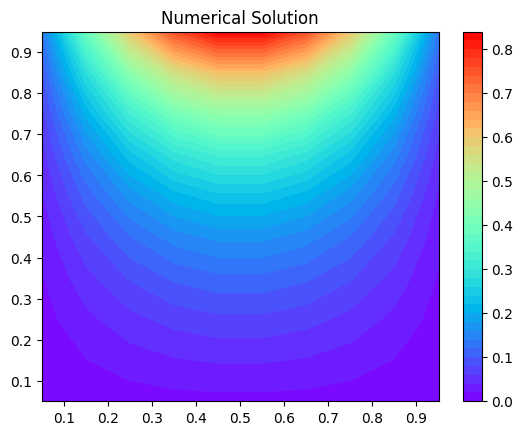

In [ ]:
T_num_im =Fully_Implicit(10,10)
print(np.round(T_num_im,4))
[m,n] = mesh(10,10)
plt.contourf(m[1:11, 1:11],n[1:11, 1:11],T_num_im,50, cmap='rainbow')
plt.title('Numerical Solution')
plt.colorbar()
plt.show()

### **3.2.7 Fully Implicit Method vs. Gauss-Seidel: Runtime Comparison**

<ipython-input-26-c83bb3da1e8c>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T[s,r] = sol[k]


CPU Time for mesh 10*10: 0.09762244099988493 seconds 
CPU Time for mesh 20*20: 1.0403924689999258 seconds 
CPU Time for mesh 40*40: 16.94305088100009 seconds 
CPU Time 10*10: 0.0788725140000679 seconds 
CPU Time 20*20: 0.7218487510001523 seconds 
CPU Time 40*40: 10.89909238700011 seconds 


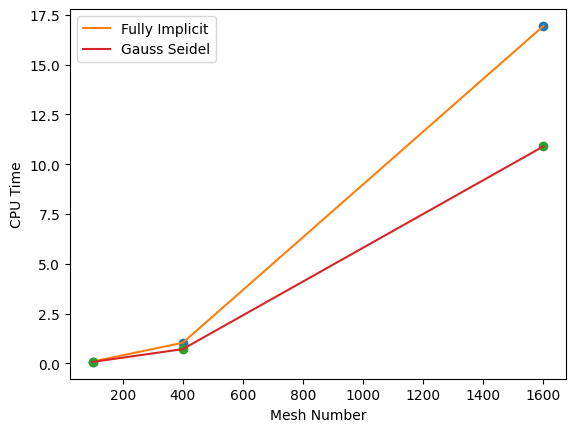

In [ ]:
start_time_im =timeit.default_timer()
T_num_im = Fully_Implicit(10,10)
end_time_im =timeit.default_timer()
CPU_Time_im = end_time_im - start_time_im
print(f"CPU Time for mesh 10*10: {CPU_Time_im} seconds ")

start_time_im2 =timeit.default_timer()
T_num_im2 = Fully_Implicit(20,20)
end_time_im2 =timeit.default_timer()
CPU_Time_im2 = end_time_im2 - start_time_im2
print(f"CPU Time for mesh 20*20: {CPU_Time_im2} seconds ")

start_time_im3 =timeit.default_timer()
T_num_im3 = Fully_Implicit(40,40)
end_time_im3 =timeit.default_timer()
CPU_Time_im3 = end_time_im3 - start_time_im3
print(f"CPU Time for mesh 40*40: {CPU_Time_im3} seconds ")

start_time_g =timeit.default_timer()
[T_num_g , iter_g, L2_g] = Gauss_Seidel(10,10,1e-12)
end_time_g =timeit.default_timer()
CPU_Time_g = end_time_g - start_time_g
print(f"CPU Time 10*10: {CPU_Time_g} seconds ")

start_time_g2 =timeit.default_timer()
[T_num_g2 , iter_g2, L2_g2] = Gauss_Seidel(20,20,1e-12)
end_time_g2 =timeit.default_timer()
CPU_Time_g2 = end_time_g2 - start_time_g2
print(f"CPU Time 20*20: {CPU_Time_g2} seconds ")

start_time_g4 =timeit.default_timer()
[T_num_g4 , iter_g4, L2_g4] = Gauss_Seidel(40,40,1e-12)
end_time_g4 =timeit.default_timer()
CPU_Time_g4 = end_time_g4 - start_time_g4
print(f"CPU Time 40*40: {CPU_Time_g4} seconds ")

x_value = [100,400,1600]
y_value_im = [CPU_Time_im, CPU_Time_im2, CPU_Time_im3]
y_value_gauss = [CPU_Time_g, CPU_Time_g2, CPU_Time_g4]
plt.plot(x_value, y_value_im,'o')
plt.plot(x_value, y_value_im, label = 'Fully Implicit')
plt.plot(x_value,y_value_gauss ,'o')
plt.plot(x_value, y_value_gauss, label = 'Gauss Seidel')
plt.xlabel('Mesh Number')
plt.ylabel('CPU Time')
plt.legend()
plt.show()


# **4. Optimized Fully Implicit Method using Sparse Matrix Representation**

In this section of the project, we implement a sparse matrix solver within the fully implicit method to evaluate its impact on computational efficiency. By leveraging sparse matrix techniques, we aim to reduce memory usage and improve runtime performance, making the fully implicit approach more scalable for larger mesh sizes.

## **4.1 Sparse Matrix Implementation in Fully Implicit Method**


In [ ]:
# Fully Implicit run time reduction using Sprase Matrix
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def Fully_Implicit(Nx, Ny):
    dx, dy = 1 / Nx, 1 / Ny
    [x, y] = mesh(Nx, Ny)
    X, Y = 1/dx**2, 1/dy**2
    T = np.zeros([Nx + 2, Ny + 2])
    A = lil_matrix((Nx*Ny+2 , Nx*Ny+2))
    B = np.zeros([Nx * Ny + 2, 1])

    for i in range(1,Nx*Ny+1):
        for j in range(1,Nx*Ny+1):
            if j == i:
                if i <= Nx or i > Nx*(Ny-1):
                    if i%Nx == 0 or i%Nx == 1:
                        A[i, j] = -3 * (X + Y)
                    else:
                        A[i, j] = -2*X-3*Y
                else:
                    if i%Nx == 0 or i%Nx == 1:
                        A[i, j] = -3 * X - 2 * Y
                    else:
                        A[i, j] = -2*(X+Y)
            elif j==i-1 and i%Nx != 1:
                A[i,j] = X
            elif j==i+1 and i%Nx != 0:
                A[i, j] = X
            elif j == i+Nx or i == Ny+j:
                A[i,j] = Y


    for k in range(1, Nx+1):
        B[k] = -2*Y*np.sin(np.pi*x[1,k])

    #sparse solver
    sol = spsolve(A.tocsr(), B)

    # Reshape 1D array of sol into 2D array of T
    r, s = 0, 1
    for k in range(1, Nx*Ny+1):
        r += 1
        T[s, r] = sol[k]
        if (k) % Nx == 0:
            s += 1
            r = 0

    return T[1:Nx+1, 1:Ny+1]


## **4.2 Performance Benchmarking: Optimized Fully Implicit vs. Gauss-Seidel**


<ipython-input-29-332ff4e2c565>:38: MatrixRankWarning: Matrix is exactly singular
  sol = spsolve(A.tocsr(), B)


CPU Time for mesh 40*40: 1.4134548910001286 seconds 


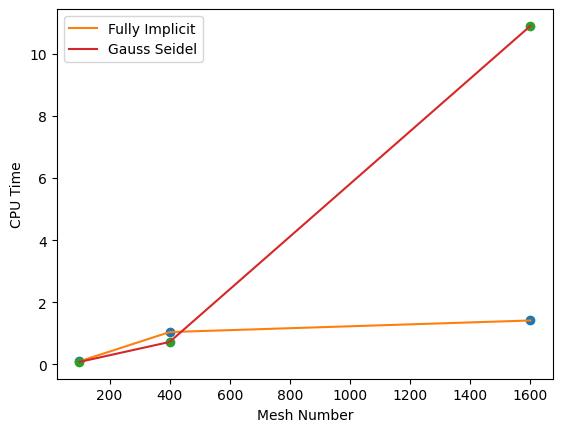

In [ ]:
# results
start_time_im4 =timeit.default_timer()
T_num_im4 = Fully_Implicit(40,40)
end_time_im4 =timeit.default_timer()
CPU_Time_im4 = end_time_im4 - start_time_im4
print(f"CPU Time for mesh 40*40: {CPU_Time_im4} seconds ")

x_value = [100,400,1600]
y_value_im = [CPU_Time_im, CPU_Time_im2, CPU_Time_im4]
y_value_gauss = [CPU_Time_g, CPU_Time_g2, CPU_Time_g4]
plt.plot(x_value, y_value_im,'o')
plt.plot(x_value, y_value_im, label = 'Fully Implicit')
plt.plot(x_value,y_value_gauss ,'o')
plt.plot(x_value, y_value_gauss, label = 'Gauss Seidel')
plt.xlabel('Mesh Number')
plt.ylabel('CPU Time')
plt.legend()
plt.show()



# **5. Comparative Analysis of All Methods Across Different Mesh Sizes**


In this section, we compare the runtime performance of all implemented numerical methods to evaluate their computational efficiency. This analysis provides insights into the relative speed and scalability of each solver when applied to the Laplace equation.

In [ ]:
start_time_GS =timeit.default_timer()
[T_num_GS , iter_GS, L2_GS] =Gauss_Seidel(10,10,1e-12)
end_time_GS =timeit.default_timer()
CPU_Time_GS = end_time_GS - start_time_GS
print(f"CPU Time for mesh 10*10: {CPU_Time_GS} seconds ")

start_time_GS2 =timeit.default_timer()
[T_num_GS2 , iter_GS2, L2_GS2] =Gauss_Seidel(20,20,1e-12)
end_time_GS2 =timeit.default_timer()
CPU_Time_GS2 = end_time_GS2 - start_time_GS2
print(f"CPU Time for mesh 20*20: {CPU_Time_GS2} seconds ")

start_time_GS4 =timeit.default_timer()
[T_num_GS4 , iter_GS4, L2_GS4] =Gauss_Seidel(40,40,1e-12)
end_time_GS4 =timeit.default_timer()
CPU_Time_GS4 = end_time_GS4 - start_time_GS4
print(f"CPU Time for mesh 40*40: {CPU_Time_GS4} seconds ")

start_time_JA =timeit.default_timer()
[T_num_JA , iter_JA, L2_JA] =Jacobi(10,10,1e-12)
end_time_JA =timeit.default_timer()
CPU_Time_JA = end_time_JA - start_time_JA
print(f"CPU Time for mesh 10*10: {CPU_Time_JA} seconds ")

start_time_JA2 =timeit.default_timer()
[T_num_JA2 , iter_JA2, L2_JA2] =Jacobi(20,20,1e-12)
end_time_JA2 =timeit.default_timer()
CPU_Time_JA2 = end_time_JA2 - start_time_JA2
print(f"CPU Time for mesh 20*20: {CPU_Time_JA2} seconds ")

start_time_JA4 =timeit.default_timer()
[T_num_JA4 , iter_JA4, L2_JA4] =Jacobi(40,40,1e-12)
end_time_JA4 =timeit.default_timer()
CPU_Time_JA4 = end_time_JA4 - start_time_JA4
print(f"CPU Time for mesh 40*40: {CPU_Time_JA4} seconds ")

start_time_S =timeit.default_timer()
[T_num_S , iter_S, L2_S] = SOR(10,10,1.5)
end_time_S =timeit.default_timer()
CPU_Time_S = end_time_S - start_time_S
print(f"CPU Time omega=1.5 for mesh 10*10: {CPU_Time_S} seconds  ")

start_time_S2 =timeit.default_timer()
[T_num_S2 , iter_S2, L2_S2] = SOR(20,20,1.5)
end_time_S2 =timeit.default_timer()
CPU_Time_S2 = end_time_S2 - start_time_S2
print(f"CPU Time omega=1.5 for mesh 20*20: {CPU_Time_S2} seconds  ")

start_time_S4 =timeit.default_timer()
[T_num_S4 , iter_S4, L2_S4] = SOR(40,40,1.5)
end_time_S4 =timeit.default_timer()
CPU_Time_S4 = end_time_S4 - start_time_S4
print(f"CPU Time omega=1.5 for mesh 40*40: {CPU_Time_S4} seconds  ")

start_time_LS =timeit.default_timer()
[T_num_LS , iter_LS, L2_LS] = LSOR(10,10,1.5)
end_time_LS =timeit.default_timer()
CPU_Time_LS = end_time_LS - start_time_LS
print(f"CPU Time omega=1.5 for mesh 10*10: {CPU_Time_LS} seconds ")

start_time_LS2 =timeit.default_timer()
[T_num_LS2 , iter_LS2, L2_LS2] = LSOR(20,20,1.5)
end_time_LS2 =timeit.default_timer()
CPU_Time_LS2 = end_time_LS2 - start_time_LS2
print(f"CPU Time omega=1.5 for mesh 20*20: {CPU_Time_LS2} seconds ")

start_time_LS4 =timeit.default_timer()
[T_num_LS4 , iter_LS4, L2_LS4] = LSOR(40,40,1.5)
end_time_LS4 =timeit.default_timer()
CPU_Time_LS4 = end_time_LS4 - start_time_LS4
print(f"CPU Time omega=1.5 for mesh 40*40: {CPU_Time_LS4} seconds ")

start_time_IM =timeit.default_timer()
T_num_IM = Fully_Implicit(10,10)
end_time_IM =timeit.default_timer()
CPU_Time_IM = end_time_IM - start_time_IM
print(f"CPU Time for mesh 10*10: {CPU_Time_IM} seconds ")

start_time_IM2 =timeit.default_timer()
T_num_IM2 = Fully_Implicit(20,20)
end_time_IM2 =timeit.default_timer()
CPU_Time_IM2 = end_time_IM2 - start_time_IM2
print(f"CPU Time for mesh 20*20: {CPU_Time_IM2} seconds ")

start_time_IM4 =timeit.default_timer()
T_num_IM4 = Fully_Implicit(40,40)
end_time_IM4 =timeit.default_timer()
CPU_Time_IM4 = end_time_IM4 - start_time_IM4
print(f"CPU Time for mesh 40*40: {CPU_Time_IM4} seconds ")


CPU Time for mesh 10*10: 0.07001176200014925 seconds 
CPU Time for mesh 20*20: 0.7466594850000092 seconds 
CPU Time for mesh 40*40: 10.973144371999979 seconds 
CPU Time for mesh 10*10: 0.1162401060000775 seconds 
CPU Time for mesh 20*20: 1.3248009380001804 seconds 
CPU Time for mesh 40*40: 18.86957152800005 seconds 
CPU Time omega=1.5 for mesh 10*10: 0.08833999199987375 seconds  
CPU Time omega=1.5 for mesh 20*20: 0.5875789740000528 seconds  
CPU Time omega=1.5 for mesh 40*40: 5.259408579000137 seconds  


<ipython-input-8-701f4e7212ea>:34: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  deltaT[1:Ny+1,j] = spsolve(A[1:Nx + 1, 1:Ny + 1],B[1:Nx + 1, 0])


CPU Time omega=1.5 for mesh 10*10: 0.276538624000068 seconds 
CPU Time omega=1.5 for mesh 20*20: 0.7471070900000996 seconds 
CPU Time omega=1.5 for mesh 40*40: 8.573712902000125 seconds 
CPU Time for mesh 10*10: 0.003288457000053313 seconds 
CPU Time for mesh 20*20: 0.024385006000102294 seconds 


<ipython-input-29-332ff4e2c565>:38: MatrixRankWarning: Matrix is exactly singular
  sol = spsolve(A.tocsr(), B)


CPU Time for mesh 40*40: 0.38255013200000576 seconds 
